# Masked Evidence Lower Bound

In [106]:
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

import io
mask_path = "~/Desktop/MCAR60_mask.csv"
X_full_path = "~/Desktop/MCAR60_X_full.csv"
X_obs_path ="~/Desktop/MCAR60_X_obs.csv"


x_full = pd.read_csv(X_full_path).to_numpy().astype("float32")
x_obs  = pd.read_csv(X_obs_path ).to_numpy().astype("float32")
mask   = pd.read_csv(mask_path  ).to_numpy().astype("float32")

x_obs = np.where(mask == 1, x_obs, 0.0)

In [107]:
print(mask.mean())
print( x_obs.mean())
print( x_full.mean())

0.59926665
nan
0.51131666


In [108]:
METHOD = "zero"   # "zero" | "enc_ind" | "enc_dec_ind"

def build_inputs(x_obs, mask, method):
    if method == "zero":
        enc_inp = x_obs
        dec_cond = None
    elif method == "enc_ind":
        enc_inp = torch.cat([x_obs, mask], dim=1)
        dec_cond = None
    elif method == "enc_dec_ind":
        enc_inp = torch.cat([x_obs, mask], dim=1)
        dec_cond = mask
    else:
        raise ValueError("Unknown method")
    return enc_inp, dec_cond

In [109]:
x_full_t = torch.from_numpy(x_full).float()
x_obs_t  = torch.from_numpy(x_obs).float()
mask_t   = torch.from_numpy(mask).float()

x_obs_t = torch.nan_to_num(x_obs_t, nan=0.0)

In [110]:
N = x_full_t.shape[0]
test_train_mask = torch.rand(N) < (1/3)   # True = test

x_full_test, x_full_train = x_full_t[test_train_mask], x_full_t[~test_train_mask]
x_obs_test,  x_obs_train  = x_obs_t [test_train_mask], x_obs_t [~test_train_mask]
mask_test,   mask_train   = mask_t  [test_train_mask], mask_t  [~test_train_mask]

In [111]:
# Model Hyperparameters

cuda = False
DEVICE = torch.device("cuda" if cuda else "cpu")

batch_size = 100

x_dim = 20
hidden_dim = 400
latent_dim = 200

lr = 1e-3

epochs = 30

In [112]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 100
kwargs = {'num_workers': 1, 'pin_memory': True}

train_ds = TensorDataset(x_obs_train, x_full_train, mask_train)
test_ds  = TensorDataset(x_obs_test,  x_full_test,  mask_test)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  **kwargs)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, **kwargs)

In [113]:
class Encoder(nn.Module):
    """Gaussian MLP Encoder."""
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean = nn.Linear(hidden_dim, latent_dim)
        self.FC_var = nn.Linear(hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

        self.training = True

    def forward(self, x):
        h_ = self.LeakyReLU(self.FC_input(x))
        h_ = self.LeakyReLU(self.FC_input2(h_))
        mean = self.FC_mean(h_)
        log_var = self.FC_var(h_)

        return mean, log_var

In [114]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, use_mask=False, x_dim=20):
        super().__init__()
        self.use_mask = use_mask
        in_dim = latent_dim + (x_dim if use_mask else 0)

        self.FC_hidden = nn.Linear(in_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, z, mask=None):
        if self.use_mask:
            z = torch.cat([z, mask], dim=1)

        h = self.LeakyReLU(self.FC_hidden(z))
        h = self.LeakyReLU(self.FC_hidden2(h))
        return torch.sigmoid(self.FC_output(h))

In [115]:
class Model(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def reparametrization(self, mean, std):
        eps = torch.randn_like(std)
        return mean + std * eps

    def forward(self, enc_inp, dec_mask=None):
        mean, log_var = self.encoder(enc_inp)
        log_var = torch.clamp(log_var, -10.0, 10.0)  # 稳定一点
        std = torch.exp(0.5 * log_var)
        z = self.reparametrization(mean, std)
        x_hat = self.decoder(z, mask=dec_mask)
        return x_hat, mean, log_var

In [116]:
enc_input_dim = x_dim if METHOD == "zero" else 2 * x_dim
use_dec_mask = (METHOD == "enc_dec_ind")

encoder = Encoder(input_dim=enc_input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim=x_dim,
                  use_mask=use_dec_mask, x_dim=x_dim)

model = Model(encoder, decoder).to(DEVICE)

### 3. Define Loss Function

In [117]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()


def loss_function(x_full, x_hat, mean, log_var, mask, beta=1.0):
    # Reconstruction loss on observed entries only
    recon_all = nn.functional.binary_cross_entropy(
        x_hat, x_full, reduction='none'
    )
    recon_obs = (recon_all * mask).sum() / (mask.sum() + 1e-8)

    # KL divergence (per batch)
    kld = -0.5 * torch.sum(
        1 + log_var - mean.pow(2) - log_var.exp()
    ) / x_full.size(0)

    return recon_obs + beta * kld


optimizer = Adam(model.parameters(), lr=lr)

### 4. Train the Model

In [118]:
from torch.optim import Adam

def train_one_method(method, train_loader, test_loader,
                     x_dim=20, hidden_dim=400, latent_dim=200,
                     lr=1e-3, epochs=30, device="cpu", beta=1.0):

    # build model dims
    enc_input_dim = x_dim if method == "zero" else 2 * x_dim
    use_dec_mask = (method == "enc_dec_ind")

    encoder = Encoder(input_dim=enc_input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
    decoder = Decoder(latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim=x_dim,
                      use_mask=use_dec_mask, x_dim=x_dim)

    model = Model(encoder, decoder).to(device)
    optimizer = Adam(model.parameters(), lr=lr)

    history = {"train_missing_bce": [], "test_missing_bce": []}

    for epoch in range(epochs):
        model.train()
        train_miss_losses = []

        for x_obs, x_full, mask in train_loader:
            x_obs = x_obs.to(device).float()
            x_full = x_full.to(device).float()
            mask = mask.to(device).float()

            enc_inp, dec_mask = build_inputs(x_obs, mask, method)

            optimizer.zero_grad()
            x_hat, mean, log_var = model(enc_inp, dec_mask)

            # loss = observed recon + KL
            recon_obs = masked_bce(x_hat, x_full, mask)
            kld = kld_loss(mean, log_var)
            loss = recon_obs + beta * kld

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()

            # track missing-only BCE as imputation metric
            miss_bce_val = missing_bce(x_hat.detach(), x_full, mask).item()
            train_miss_losses.append(miss_bce_val)

        # evaluate missing BCE on test
        model.eval()
        test_miss_losses = []
        with torch.no_grad():
            for x_obs, x_full, mask in test_loader:
                x_obs = x_obs.to(device).float()
                x_full = x_full.to(device).float()
                mask = mask.to(device).float()

                enc_inp, dec_mask = build_inputs(x_obs, mask, method)
                x_hat, mean, log_var = model(enc_inp, dec_mask)

                test_miss_losses.append(missing_bce(x_hat, x_full, mask).item())

        history["train_missing_bce"].append(float(np.mean(train_miss_losses)))
        history["test_missing_bce"].append(float(np.mean(test_miss_losses)))

        print(f"[{method}] Epoch {epoch+1:02d} | "
              f"train missing BCE={history['train_missing_bce'][-1]:.4f} | "
              f"test missing BCE={history['test_missing_bce'][-1]:.4f}")

    return model, history

In [119]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

def masked_bce(x_hat, x_target, mask):
    """BCE only on mask==1 entries"""
    bce = F.binary_cross_entropy(x_hat, x_target, reduction="none")
    return (bce * mask).sum() / (mask.sum() + 1e-8)

def missing_bce(x_hat, x_target, mask):
    """BCE only on missing entries (mask==0)"""
    bce = F.binary_cross_entropy(x_hat, x_target, reduction="none")
    miss = 1.0 - mask
    return (bce * miss).sum() / (miss.sum() + 1e-8)

def kld_loss(mean, log_var):
    return -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp()) / mean.size(0)

In [120]:
METHODS = ["zero", "enc_ind", "enc_dec_ind"]

all_hist = {}
final_scores = {}

for METHOD in METHODS:
    print("\n==============================")
    print("Running:", METHOD)
    print("==============================")

    model, hist = train_one_method(
        method=METHOD,
        train_loader=train_loader,
        test_loader=test_loader,
        x_dim=x_dim,
        hidden_dim=hidden_dim,
        latent_dim=latent_dim,
        lr=lr,
        epochs=epochs,
        device=DEVICE,
        beta=1.0
    )

    all_hist[METHOD] = hist
    final_scores[METHOD] = hist["test_missing_bce"][-1]


Running: zero


/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[zero] Epoch 01 | train missing BCE=0.6379 | test missing BCE=0.6306
[zero] Epoch 02 | train missing BCE=0.6280 | test missing BCE=0.6314
[zero] Epoch 03 | train missing BCE=0.6266 | test missing BCE=0.6314
[zero] Epoch 04 | train missing BCE=0.6269 | test missing BCE=0.6329
[zero] Epoch 05 | train missing BCE=0.6263 | test missing BCE=0.6296
[zero] Epoch 06 | train missing BCE=0.6245 | test missing BCE=0.6297
[zero] Epoch 07 | train missing BCE=0.6242 | test missing BCE=0.6309
[zero] Epoch 08 | train missing BCE=0.6263 | test missing BCE=0.6310
[zero] Epoch 09 | train missing BCE=0.6257 | test missing BCE=0.6281
[zero] Epoch 10 | train missing BCE=0.6275 | test missing BCE=0.6297
[zero] Epoch 11 | train missing BCE=0.6284 | test missing BCE=0.6286
[zero] Epoch 12 | train missing BCE=0.6256 | test missing BCE=0.6293
[zero] Epoch 13 | train missing BCE=0.6241 | test missing BCE=0.6280
[zero] Epoch 14 | train missing BCE=0.6260 | test missing BCE=0.6306
[zero] Epoch 15 | train missing BC

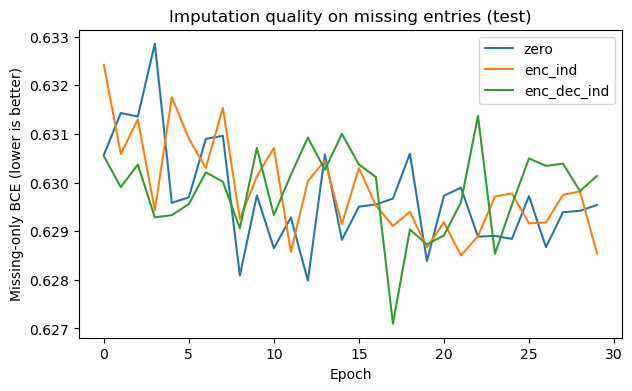

In [121]:
plt.figure(figsize=(7,4))
for METHOD in METHODS:
    plt.plot(all_hist[METHOD]["test_missing_bce"], label=METHOD)
plt.xlabel("Epoch")
plt.ylabel("Missing-only BCE (lower is better)")
plt.title("Imputation quality on missing entries (test)")
plt.legend()
plt.show()